In [2]:
from robovast.common.analysis import read_output_files, read_output_csv, get_behavior_info
import pandas as pd
from robovast_nav.gui import MapVisualizer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
DATA_DIR = '/home/fred/git/robovast/results/run-2026-02-11-203525'

df = read_output_files(DATA_DIR, lambda test_dir: read_output_csv(test_dir, "poses.csv"))

# Check if DataFrame is empty
if df.empty:
    raise ValueError(f"No pose data found in {DATA_DIR}")

# Generate colors for each test
tests = df['test'].unique()
configs = df['config'].unique()

# Check if we have any tests or configs
if len(tests) == 0 or len(configs) == 0:
    raise ValueError("No tests or configs found in the data")

colors = cm.rainbow(np.linspace(0, 1, len(tests)))

df_behaviors = read_output_files(DATA_DIR, lambda test_dir: read_output_csv(test_dir, "behaviors.csv"))

if df_behaviors.empty:
    raise ValueError(f"No behavior data found in {DATA_DIR}")

df_behavior_info = get_behavior_info('differential_drive_robot.nav_to_pose', df_behaviors)

## Overview

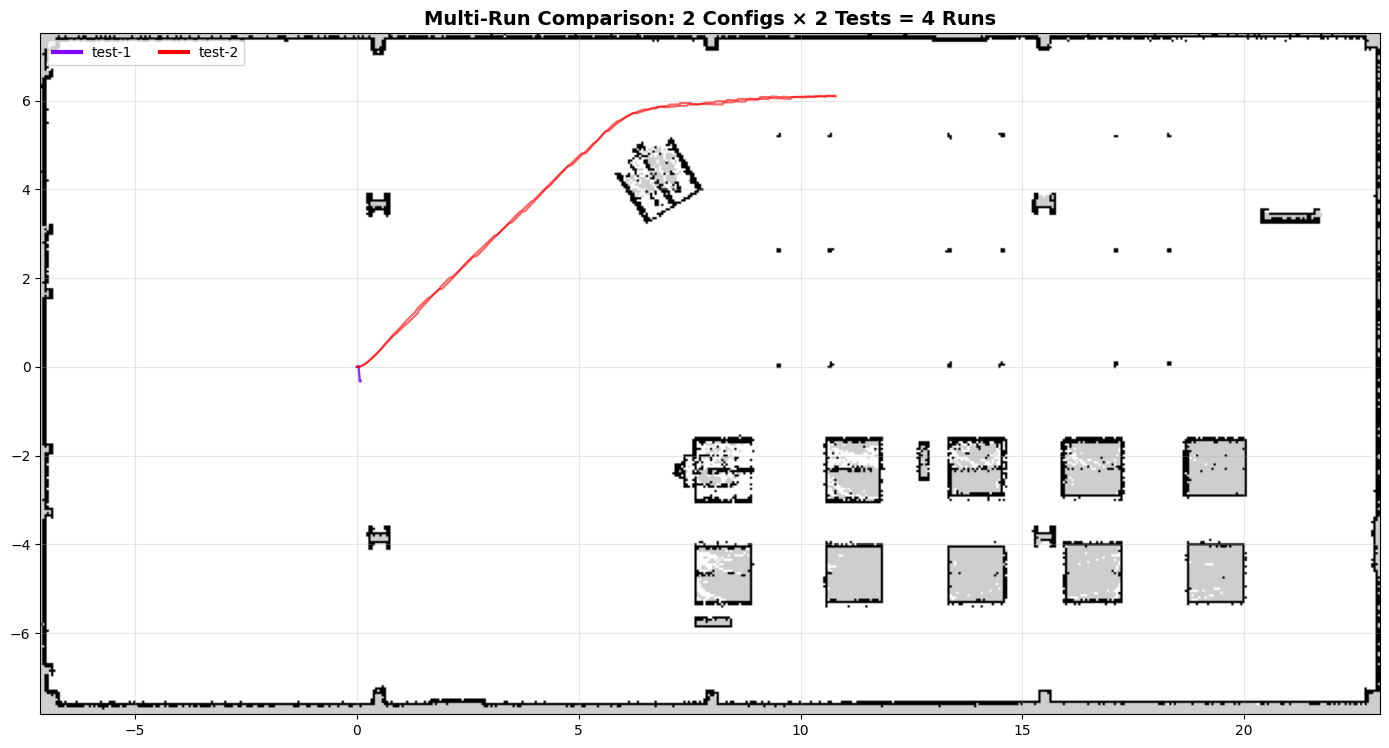

In [3]:
# Multi-Run Comparison: All Robot Paths by Test Config

# Generate colors for configs (not tests)
config_colors = cm.rainbow(np.linspace(0, 1, len(configs)))

# Create single visualization with all robot paths
viz = MapVisualizer()
viz.load_map("/opt/ros/jazzy/share/nav2_bringup/maps/depot.yaml")
viz.create_figure(figsize=(14, 12))

# Draw all robot paths grouped by config
for i, config in enumerate(configs):
    df_config = df[df['config'] == config]
    
    # Draw all tests for this config
    for test in tests:
        df_test_config = df_config[df_config['test'] == test]
        
        if df_test_config.empty:
            continue
            
        # Filter for robot base_link data
        df_robot_test = df_test_config[df_test_config['frame'] == 'base_link']
        
        if df_robot_test.empty:
            continue
            
        path_robot = list(zip(df_robot_test['position.x'], df_robot_test['position.y']))
        
        if len(path_robot) > 0:
            viz.draw_path(path_robot, color=config_colors[i], linewidth=1.5, 
                         alpha=0.6, show_endpoints=False)

# Add legend with config labels
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=config_colors[i], linewidth=3, label=config) 
                   for i, config in enumerate(configs)]
viz.ax.legend(handles=legend_elements, loc='upper left', fontsize=10, ncol=2)

viz.ax.set_title(f'Multi-Run Comparison: {len(configs)} Configs × {len(tests)} Tests = {len(configs)*len(tests)} Runs', 
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Navigation Duration Analysis

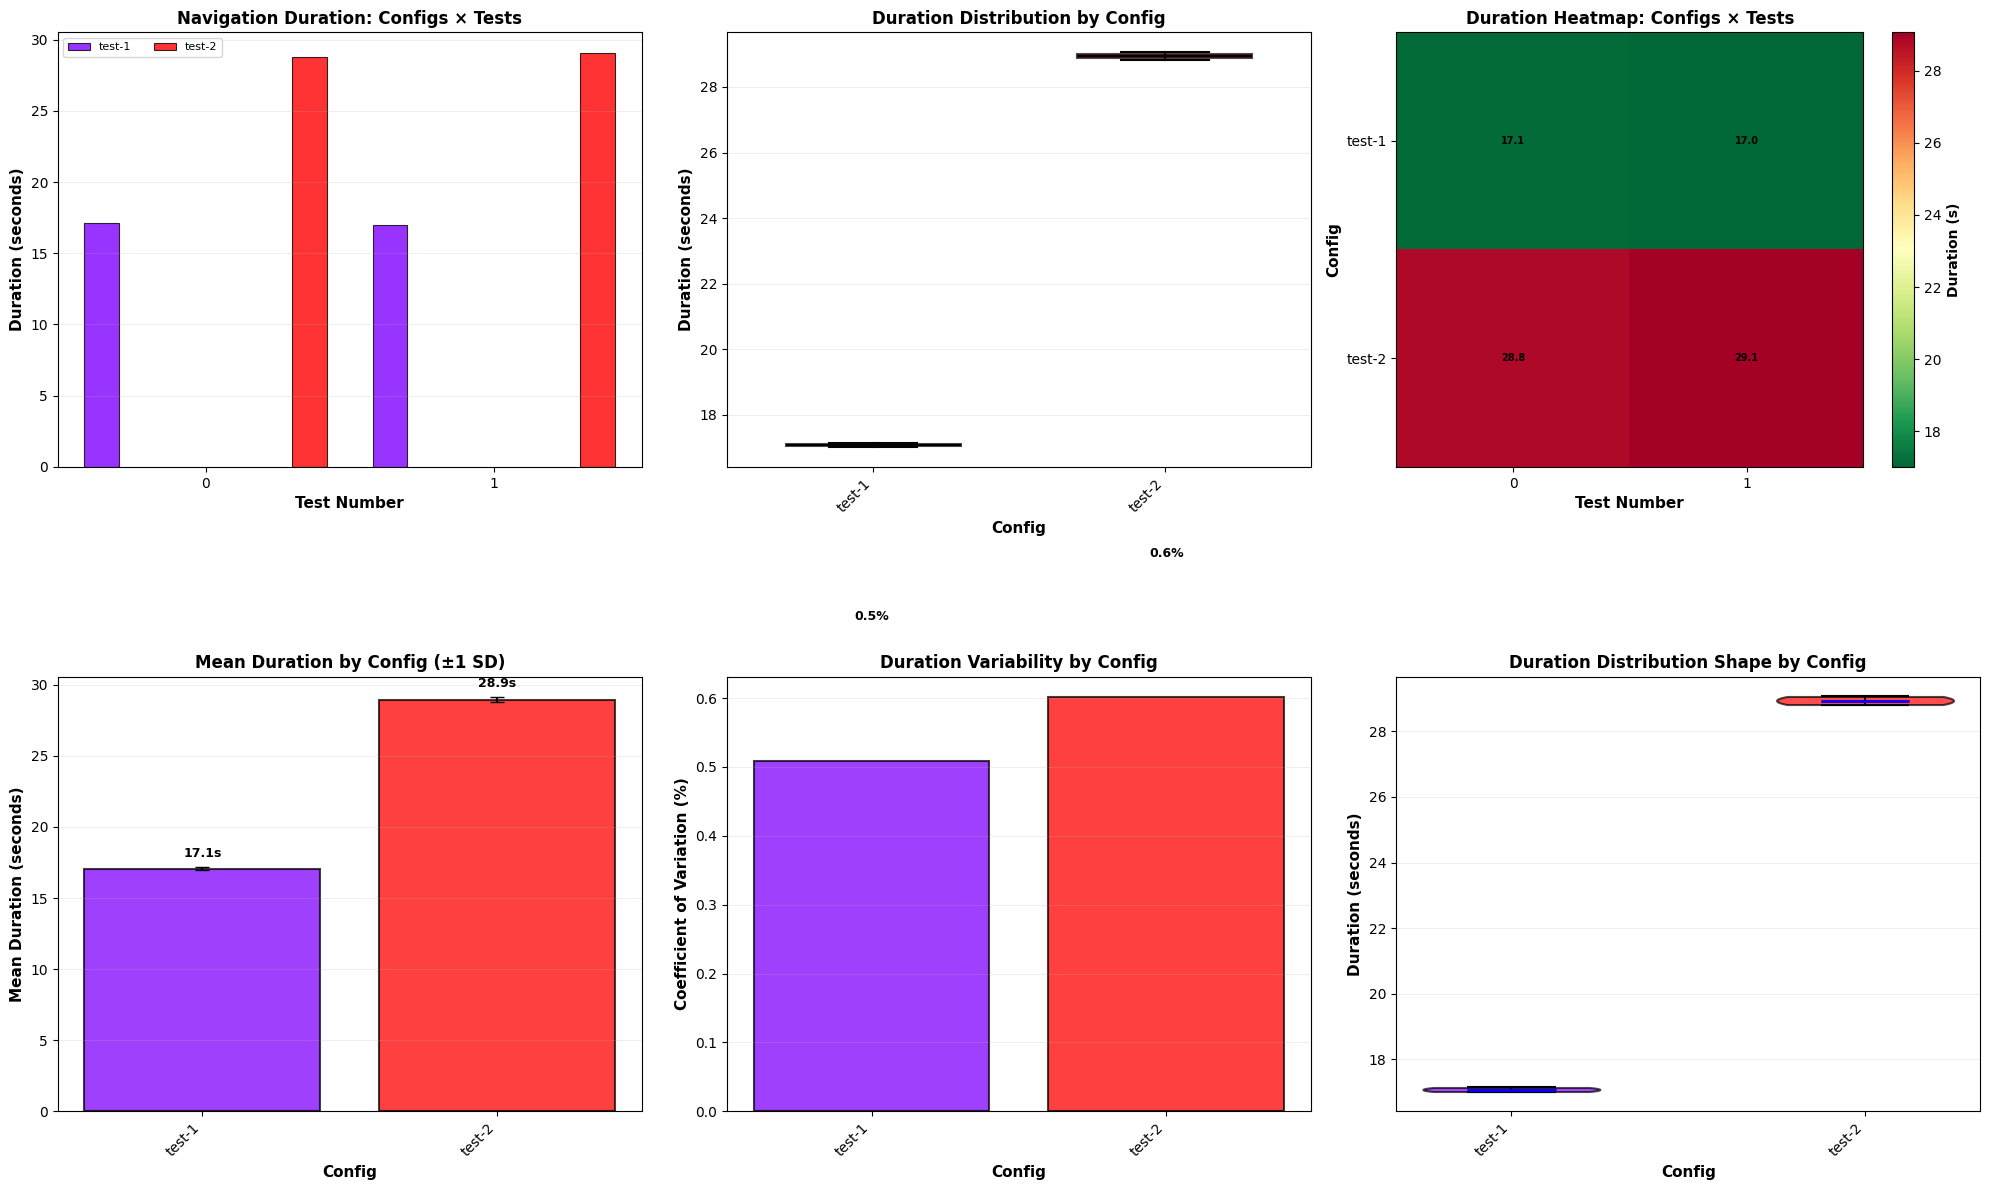


MULTI-CONFIG DURATION ANALYSIS SUMMARY

test-1:
  Mean: 17.08s (±0.06s)
  Range: [17.02s, 17.14s]
  CV: 0.4%

test-2:
  Mean: 28.94s (±0.12s)
  Range: [28.82s, 29.06s]
  CV: 0.4%


In [4]:
# Multi-Config + Multi-Test Navigation Duration Analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Use df_behavior_info directly - it already has one row per test-config combination
df_duration_summary = df_behavior_info[['config', 'test', 'duration']].copy()

if df_duration_summary.empty:
    print("No duration data available")
    plt.close()
else:
    # Create a pivot table for easier access
    duration_pivot = df_duration_summary.pivot(index='config', columns='test', values='duration')

    # Sort configs to match our color scheme
    duration_pivot = duration_pivot.reindex(configs)

    # 1. Grouped Bar Chart - Duration by Config and Test
    ax = axes[0, 0]
    x = np.arange(len(tests))
    width = 0.12  # Width of bars
    offsets = np.linspace(-3*width, 3*width, len(configs))

    sorted_tests_list = sorted([str(t) for t in tests])
    for i, config in enumerate(configs):
        config_data = df_duration_summary[df_duration_summary['config'] == config].copy()
        if len(config_data) > 0:
            # Create array with NaN for missing tests
            durations = []
            for test in sorted_tests_list:
                test_data = config_data[config_data['test'] == test]
                if len(test_data) > 0:
                    durations.append(test_data['duration'].values[0])
                else:
                    durations.append(np.nan)
            
            # Only plot non-NaN values
            durations = np.array(durations)
            valid_mask = ~np.isnan(durations)
            if valid_mask.any():
                ax.bar(x[valid_mask] + offsets[i], durations[valid_mask], width, label=config, 
                       color=config_colors[i], alpha=0.8, edgecolor='black', linewidth=0.8)

    ax.set_xlabel('Test Number', fontsize=11, fontweight='bold')
    ax.set_ylabel('Duration (seconds)', fontsize=11, fontweight='bold')
    ax.set_title('Navigation Duration: Configs × Tests', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_tests_list)
    ax.legend(fontsize=8, ncol=2, loc='upper left')
    ax.grid(True, alpha=0.3, axis='y', linewidth=0.5)

    # 2. Box Plot - Duration Distribution by Config
    ax = axes[0, 1]
    config_duration_list = [df_duration_summary[df_duration_summary['config'] == v]['duration'].values 
                             for v in configs]
    
    # Filter out empty arrays
    config_duration_list = [arr for arr in config_duration_list if len(arr) > 0]
    config_labels = [config for i, config in enumerate(configs) 
                     if len(df_duration_summary[df_duration_summary['config'] == config]) > 0]
    
    if len(config_duration_list) > 0:
        bp = ax.boxplot(config_duration_list, tick_labels=config_labels, patch_artist=True, widths=0.6)

        for patch, color in zip(bp['boxes'], config_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
            patch.set_edgecolor('black')
            patch.set_linewidth(1.5)

        for element in ['whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(bp[element], color='black', linewidth=1.5)

    ax.set_xlabel('Config', fontsize=11, fontweight='bold')
    ax.set_ylabel('Duration (seconds)', fontsize=11, fontweight='bold')
    ax.set_title('Duration Distribution by Config', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linewidth=0.5)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # 3. Heatmap - Duration across Configs and Tests
    ax = axes[0, 2]
    duration_matrix = duration_pivot.values
    im = ax.imshow(duration_matrix, cmap='RdYlGn_r', aspect='auto')
    ax.set_xticks(np.arange(len(sorted_tests_list)))
    ax.set_yticks(np.arange(len(configs)))
    ax.set_xticklabels(sorted_tests_list)
    ax.set_yticklabels(configs)
    ax.set_xlabel('Test Number', fontsize=11, fontweight='bold')
    ax.set_ylabel('Config', fontsize=11, fontweight='bold')
    ax.set_title('Duration Heatmap: Configs × Tests', fontsize=12, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Duration (s)', fontsize=10, fontweight='bold')

    # Add text annotations
    for i in range(len(configs)):
        for j in range(len(sorted_tests_list)):
            if not np.isnan(duration_matrix[i, j]):
                text = ax.text(j, i, f'{duration_matrix[i, j]:.1f}',
                              ha="center", va="center", color="black", fontsize=7, fontweight='bold')

    # 4. Mean Duration by Config with Error Bars
    ax = axes[1, 0]
    config_means = [df_duration_summary[df_duration_summary['config'] == v]['duration'].mean() 
                     for v in configs]
    config_stds = [df_duration_summary[df_duration_summary['config'] == v]['duration'].std() 
                    for v in configs]
    x_pos = np.arange(len(configs))

    bars = ax.bar(x_pos, config_means, yerr=config_stds, capsize=5, 
                  alpha=0.75, color=config_colors, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Config', fontsize=11, fontweight='bold')
    ax.set_ylabel('Mean Duration (seconds)', fontsize=11, fontweight='bold')
    ax.set_title('Mean Duration by Config (±1 SD)', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(configs)
    ax.grid(True, alpha=0.3, axis='y', linewidth=0.5)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Add value labels
    for i, (mean, std) in enumerate(zip(config_means, config_stds)):
        if not np.isnan(mean) and not np.isnan(std):
            ax.text(i, mean + std + 0.5, f'{mean:.1f}s', ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')

    # 5. Coefficient of Variation by Config
    ax = axes[1, 1]
    config_cv = []
    for v in configs:
        data = df_duration_summary[df_duration_summary['config'] == v]['duration']
        if len(data) > 0 and data.mean() != 0:
            cv = (data.std() / data.mean()) * 100
            config_cv.append(cv)
        else:
            config_cv.append(0)

    bars = ax.bar(x_pos, config_cv, alpha=0.75, color=config_colors, 
                  edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Config', fontsize=11, fontweight='bold')
    ax.set_ylabel('Coefficient of Variation (%)', fontsize=11, fontweight='bold')
    ax.set_title('Duration Variability by Config', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(configs)
    ax.grid(True, alpha=0.3, axis='y', linewidth=0.5)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Add value labels
    for i, cv in enumerate(config_cv):
        if cv > 0:
            ax.text(i, cv + 0.2, f'{cv:.1f}%', ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')

    # 6. Violin Plot - Duration Distribution by Config
    ax = axes[1, 2]
    if len(config_duration_list) > 0:
        parts = ax.violinplot(config_duration_list, positions=range(len(config_labels)), 
                              showmeans=True, showmedians=True)

        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(config_colors[i])
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
            pc.set_linewidth(1.5)

        plt.setp(parts['cmeans'], color='red', linewidth=2)
        plt.setp(parts['cmedians'], color='blue', linewidth=2)
        plt.setp(parts['cbars'], color='black', linewidth=1.5)
        plt.setp(parts['cmaxes'], color='black', linewidth=1.5)
        plt.setp(parts['cmins'], color='black', linewidth=1.5)

        ax.set_xticks(range(len(config_labels)))
        ax.set_xticklabels(config_labels)

    ax.set_xlabel('Config', fontsize=11, fontweight='bold')
    ax.set_ylabel('Duration (seconds)', fontsize=11, fontweight='bold')
    ax.set_title('Duration Distribution Shape by Config', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y', linewidth=0.5)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*80)
    print("MULTI-CONFIG DURATION ANALYSIS SUMMARY")
    print("="*80)
    for config in configs:
        durations = df_duration_summary[df_duration_summary['config'] == config]['duration'].values
        if len(durations) > 0:
            mean = durations.mean()
            std = durations.std()
            min_val = durations.min()
            max_val = durations.max()
            cv = (std/mean)*100 if mean != 0 else 0
            
            print(f"\n{config}:")
            print(f"  Mean: {mean:.2f}s (±{std:.2f}s)")
            print(f"  Range: [{min_val:.2f}s, {max_val:.2f}s]")
            print(f"  CV: {cv:.1f}%")
        else:
            print(f"\n{config}: No data available")
    print("="*80)